In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
import numpy as np
import random
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.metrics import precision_recall_fscore_support
from langdetect import detect, DetectorFactory
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedShuffleSplit


In [32]:
# Configuration de l'authentification Google Cloud
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "credentials.json"


In [33]:
# Télécharger les ressources nécessaires de nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cyrine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

VISUALISATION DES DONNEES

In [34]:
# Charger les données
with open('balanced_data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    

['arts and music', 'travel', 'politics and social issues', 'live events', 'vehicles', 'photography', 'shopping and fashion', 'sports', 'family and relationships', 'pets', 'acting', 'beauty', 'food and drink']
[117, 127, 101, 115, 110, 114, 113, 105, 115, 96, 121, 127, 118]


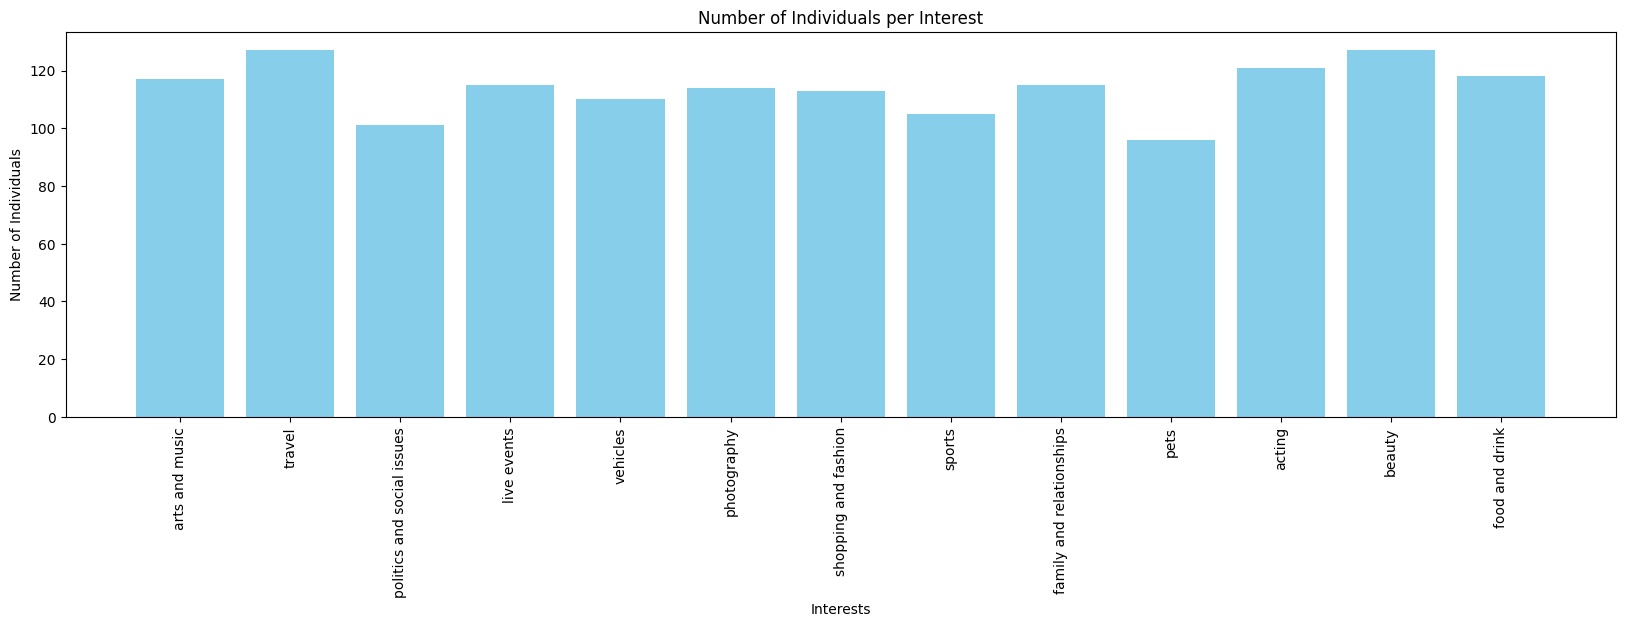

In [36]:
# Visualisation des intérêts avant le prétraitement
interests = []
for person in data:
    if 'interests' in person:
        interests.extend([interest.strip().lower() for interest in person['interests'].split(',')])

interest_count = Counter(interests)
labels = list(interest_count.keys())
values = list(interest_count.values())

print(labels)
print(values)
plt.figure(figsize=(20, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Interests')
plt.ylabel('Number of Individuals')
plt.title('Number of Individuals per Interest')
plt.xticks(rotation=90)
plt.show()


PRETRAITEMENT DU TEXTE

In [5]:
# Chargement du tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


c:\Users\cyrine\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Définir la graine pour la reproductibilité pour la detection de langues
DetectorFactory.seed = 0


In [37]:
# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'en'  # par défaut, l'anglais si la détection échoue
    

In [38]:
# Fonction pour supprimer les stop words en utilisant le tokenizer de BERT
def remove_stopwords(text, language):
    try:
        stop_words = set(stopwords.words(language))
    except:
        stop_words = set(stopwords.words('english'))
    
    # Utiliser le tokenizer de BERT pour diviser le texte en mots
    tokens = tokenizer.basic_tokenizer.tokenize(text)
    
    # Filtrer les stop words
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    return filtered_tokens


In [39]:
# Fonction pour nettoyer les tokens en supprimant les préfixes '##'
def clean_tokenized_text(tokenized_text):
    cleaned_tokens = []
    for token in tokenized_text:
        if token.startswith("##"):
            if len(cleaned_tokens) > 0:
                cleaned_tokens[-1] += token[2:]
        else:
            cleaned_tokens.append(token)
    return ' '.join(cleaned_tokens)


In [40]:
# Nouvelle fonction de prétraitement du texte
def preprocess_text(text):
    # Suppression des URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Conversion des caractères spéciaux en caractères ASCII
    text = unidecode(text)
    # Normalisation des caractères en minuscules
    text = text.lower()
    # Extraction des hashtags
    hashtags = re.findall(r'#\w+', text)
    # Suppression des hashtags du texte
    text = re.sub(r'#\w+', '', text)
    # Suppression des caractères non alphabétiques et non numériques
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Détection de la langue
    language = detect_language(text)
    # Suppression des stop words en utilisant le tokenizer de BERT
    filtered_tokens = remove_stopwords(text, language)
    # Nettoyage des tokens
    cleaned_text = clean_tokenized_text(filtered_tokens)
    return cleaned_text, ' '.join(hashtags)


In [41]:
# Chargement et prétraitement des biographies et des captions
biographies = [user['biography'] for user in data]
captions = [' '.join(post['caption'] for post in user['latestPosts']) for user in data]


In [42]:
# Ajout de vérification et de débogage pour le prétraitement
processed_biographies = []
for text in biographies:
    try:
        processed_bio, _ = preprocess_text(text)
        processed_biographies.append(processed_bio)
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")

processed_captions = []
hashtags = []
for text in captions:
    try:
        processed_caption, hashtags_text = preprocess_text(text)
        processed_captions.append(processed_caption)
        hashtags.append(hashtags_text)
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")

In [14]:
# Vérification des données prétraitées
print("Processed Biographies:", processed_biographies[:5])  # Afficher les 5 premiers éléments pour vérification
print("Processed Captions:", processed_captions[:5])  # Afficher les 5 premiers éléments pour vérification
print("Hashtags:", hashtags[:5])  # Afficher les 5 premiers éléments pour vérification


Processed Biographies: ['citizen earth books obama intimate portrait shade tale two presidents available bookstores', 'human trying mess', 'yep im guy rally rx gymkhana gymkhana grid kens account used keep kens legacy alive inquiries info43iorg', 'mother wife actor melody maker hoofer world explorer interiors fanatic', '']
Processed Captions: ['congrats friend terry szuplat former white house speechwriter forthcoming book see cover second photo terry collaborated president obama many key foreign speeches please consider preordering book available usual places stunning set janelle monae brandi carliles music festival last week mexico looking back 2023a favorites two granddaughters main photographic subjects presidential football access happy super bowl sunday today jackie robinson day every major league baseball player wear today honor robinson broke baseballs color barrier major league debut day 1947 photo 1 president obama views jackie robinson exhibit baseball hall fame 2014 photo 2 

In [43]:
# Préparation des labels
labels = [user['interests'].split(',') for user in data]
print(labels)


[['Arts and music', 'Travel', 'Politics and social issues'], ['Arts and music', 'Live events'], ['Vehicles', 'Photography'], ['Shopping and fashion', ' Travel'], ['Shopping and fashion', 'Sports'], ['Arts and music', 'Politics and social issues', 'Shopping and Fashion'], ['Family and relationships', 'Pets', 'Travel'], ['Vehicles', 'Photography', 'Travel'], ['Sports'], ['Sports'], ['Travel', 'Photography', 'Sports'], ['Family and relationships', 'Acting'], ['Travel', 'Photography'], ['Shopping and fashion', 'Travel'], ['Vehicles'], ['Arts and music', 'Acting'], ['Sports', ' Vehicles'], ['Arts and music', 'Acting'], ['Arts and music', 'Acting'], ['Arts and music', 'Politics and social issues'], ['Beauty', 'Travel'], ['Shopping and Fashion'], ['Sports', 'Family and relationships', 'Politics and social issues'], ['Arts and music'], ['Food and drink', 'Travel'], ['Arts and music', 'Politics and social issues', 'Pets'], ['Sports', 'Photography', 'Travel'], ['Photography', 'Travel'], ['Acting

In [44]:
def clean_labels(label_list):
    return set(label.strip().lower() for label in label_list)

    

In [45]:
cleaned_labels = [clean_labels(label) for label in labels]
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(cleaned_labels)


In [17]:
print(mlb.classes_)

['acting' 'arts and music' 'beauty' 'family and relationships'
 'food and drink' 'live events' 'pets' 'photography'
 'politics and social issues' 'shopping and fashion' 'sports' 'travel'
 'vehicles']


In [19]:
# Afficher les labels nettoyés
for i, labels_set in enumerate(cleaned_labels[:5]):  # Afficher les 5 premiers pour vérification
    print(f"Original labels for user {i + 1}: {labels[i]}")
    print(f"Cleaned labels for user {i + 1}: {labels_set}")
    

Original labels for user 1: ['Arts and music', 'Travel', 'Politics and social issues']
Cleaned labels for user 1: {'travel', 'arts and music', 'politics and social issues'}
Original labels for user 2: ['Arts and music', 'Live events']
Cleaned labels for user 2: {'live events', 'arts and music'}
Original labels for user 3: ['Vehicles', 'Photography']
Cleaned labels for user 3: {'photography', 'vehicles'}
Original labels for user 4: ['Shopping and fashion', ' Travel']
Cleaned labels for user 4: {'shopping and fashion', 'travel'}
Original labels for user 5: ['Shopping and fashion', 'Sports']
Cleaned labels for user 5: {'sports', 'shopping and fashion'}


In [20]:
# Afficher les labels binarisés
print("Binary labels (first 5 users):")
print(binary_labels[:5])


Binary labels (first 5 users):
[[0 1 0 0 0 0 0 0 1 0 0 1 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0]]


In [46]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Initialisation du séparateur
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [17]:
# Compter les occurrences de chaque classe
class_counts = np.sum(binary_labels, axis=0)
print(class_counts)

[121 117 127 115 118 114  96 114 101 113 105 127 110]


In [47]:
# Utilisation du séparateur
for train_index, test_index in mskf.split(processed_biographies, binary_labels):
    bio_train, bio_test = [processed_biographies[i] for i in train_index], [processed_biographies[i] for i in test_index]
    captions_train, captions_test = [processed_captions[i] for i in train_index], [processed_captions[i] for i in test_index]
    hashtags_train, hashtags_test = [hashtags[i] for i in train_index], [hashtags[i] for i in test_index]
    labels_train, labels_test = binary_labels[train_index], binary_labels[test_index]
    break  # Pour ne faire qu'une seule division pour le moment

# Vérification de la répartition des classes dans les ensembles de train et test
print("Répartition des classes dans l'ensemble d'entraînement :")
print(np.sum(labels_train, axis=0))

print("Répartition des classes dans l'ensemble de test :")
print(np.sum(labels_test, axis=0))

Répartition des classes dans l'ensemble d'entraînement :
[ 97  94 102  92  95  91  77  92  81  91  84 101  88]
Répartition des classes dans l'ensemble de test :
[24 23 25 23 23 23 19 22 20 22 21 26 22]


MODELISATION

In [48]:
# Définir la variable `device`
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du dispositif : {device}")


Utilisation du dispositif : cpu


In [25]:
import torch
print(torch.cuda.is_available())


False


In [49]:
# Définition du Dataset pour l'entraînement (gère la tokenisation des textes et l'encodage des entrées pour BERT)
class TextDataset(Dataset):
    def __init__(self, bio_texts, caption_texts, hashtag_texts, labels, tokenizer, max_len):
        self.bio_texts = bio_texts
        self.caption_texts = caption_texts
        self.hashtag_texts = hashtag_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.bio_texts)

    def __getitem__(self, idx):
        bio_text = self.bio_texts[idx]
        caption_text = self.caption_texts[idx]
        hashtag_text = self.hashtag_texts[idx]
        label = self.labels[idx]
        bio_encoding = self.tokenizer(
            bio_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True, 
            return_tensors='pt',
        )
        caption_encoding = self.tokenizer(
            caption_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        hashtag_encoding = self.tokenizer(
            hashtag_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'bio_input_ids': bio_encoding['input_ids'].flatten(),
            'bio_attention_mask': bio_encoding['attention_mask'].flatten(),
            'caption_input_ids': caption_encoding['input_ids'].flatten(),
            'caption_attention_mask': caption_encoding['attention_mask'].flatten(),
            'hashtag_input_ids': hashtag_encoding['input_ids'].flatten(),
            'hashtag_attention_mask': hashtag_encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }
    

In [50]:
# Définition du modèle
class BERTInstagramClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(0.1)
        self.bio_out = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.caption_out = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.hashtag_out = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, bio_input_ids, bio_attention_mask, caption_input_ids, caption_attention_mask, hashtag_input_ids, hashtag_attention_mask):
        bio_outputs = self.bert(input_ids=bio_input_ids, attention_mask=bio_attention_mask)
        bio_pooled_output = self.dropout(bio_outputs.pooler_output)
        bio_output = self.bio_out(bio_pooled_output)
        
        caption_outputs = self.bert(input_ids=caption_input_ids, attention_mask=caption_attention_mask)
        caption_pooled_output = self.dropout(caption_outputs.pooler_output)
        caption_output = self.caption_out(caption_pooled_output)
        
        hashtag_outputs = self.bert(input_ids=hashtag_input_ids, attention_mask=hashtag_attention_mask)
        hashtag_pooled_output = self.dropout(hashtag_outputs.pooler_output)
        hashtag_output = self.hashtag_out(hashtag_pooled_output)
        
        combined_output = bio_output + caption_output + hashtag_output 
        return combined_output

In [51]:
# Fonction d'entraînement
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    loss_fn = nn.BCEWithLogitsLoss()

    for d in data_loader:
        bio_input_ids = d['bio_input_ids'].to(device)
        bio_attention_mask = d['bio_attention_mask'].to(device)
        caption_input_ids = d['caption_input_ids'].to(device)
        caption_attention_mask = d['caption_attention_mask'].to(device)
        hashtag_input_ids = d['hashtag_input_ids'].to(device)
        hashtag_attention_mask = d['hashtag_attention_mask'].to(device)
        labels = d['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(bio_input_ids, bio_attention_mask, caption_input_ids, caption_attention_mask, hashtag_input_ids, hashtag_attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

In [52]:
# Fonction d'évaluation
def evaluate_model(model, data_loader, device, loss_fn):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad(): 
        for d in data_loader:
            bio_input_ids = d['bio_input_ids'].to(device)
            bio_attention_mask = d['bio_attention_mask'].to(device)
            caption_input_ids = d['caption_input_ids'].to(device)
            caption_attention_mask = d['caption_attention_mask'].to(device)
            hashtag_input_ids = d['hashtag_input_ids'].to(device)
            hashtag_attention_mask = d['hashtag_attention_mask'].to(device)
            labels = d['labels'].to(device)
            outputs = model(bio_input_ids, bio_attention_mask, caption_input_ids, caption_attention_mask, hashtag_input_ids, hashtag_attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            all_labels.append(labels.cpu()) 
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=1)
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    class_metrics = precision_recall_fscore_support(all_labels, all_preds, zero_division=1)
    return precision, recall, f1, avg_loss, accuracy, class_metrics


In [53]:
# Définir quelques hyperparamètres
BATCH_SIZE = 16
EPOCHS = 10
MAX_LEN = 256

In [54]:
# Créer les DataLoaders
train_dataset = TextDataset(bio_train, captions_train, hashtags_train, labels_train, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TextDataset(bio_test, captions_test, hashtags_test, labels_test, tokenizer, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [55]:
# Initialiser le modèle
model = BERTInstagramClassifier(len(mlb.classes_)).to(device)
model = model.to(device)

c:\Users\cyrine\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [56]:
# Définir l'optimiseur et le scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


c:\Users\cyrine\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [57]:
# Fonction d'entraînement principale
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs):
    history = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1': [], 'accuracy': []}
    best_val_loss = float('inf')
    loss_fn = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)
        
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f'Train loss: {train_loss}')
        
        precision, recall, f1, val_loss, accuracy, class_metrics = evaluate_model(model, val_loader, device, loss_fn)
        print(f'Validation loss: {val_loss}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Accuracy: {accuracy}')
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        history['accuracy'].append(accuracy)
        
        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} with validation loss {val_loss}')
        
    return history


In [36]:
# Entraîner le modèle
history = train_model(model, train_loader, val_loader, optimizer, scheduler, device, EPOCHS)

Epoch 1/10
----------
Train loss: 0.4150798570278079
Validation loss: 0.3697728623043407
Precision: 0.9914529914529915
Recall: 0.02564102564102564
F1 Score: 0.037296037296037296
Accuracy: 0.0
Model saved at epoch 1 with validation loss 0.3697728623043407
Epoch 2/10
----------
Train loss: 0.3482044297595357
Validation loss: 0.3198525621132417
Precision: 0.8655909374026783
Recall: 0.1768152823530398
F1 Score: 0.21880418832205228
Accuracy: 0.13953488372093023
Model saved at epoch 2 with validation loss 0.3198525621132417
Epoch 3/10
----------
Train loss: 0.28951165530570716
Validation loss: 0.28350323709574615
Precision: 0.8944669365721997
Recall: 0.23525884489271215
F1 Score: 0.2831644896293014
Accuracy: 0.21511627906976744
Model saved at epoch 3 with validation loss 0.28350323709574615
Epoch 4/10
----------
Train loss: 0.23936575893745865
Validation loss: 0.2561295811425556
Precision: 0.8874542124542124
Recall: 0.3615446300457742
F1 Score: 0.44032961735620724
Accuracy: 0.348837209302325

In [ ]:
model_save_path = "bert_instagram_classifier.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

VISUALISATION DES RESULTATS DE L'ENTRAINEMENT


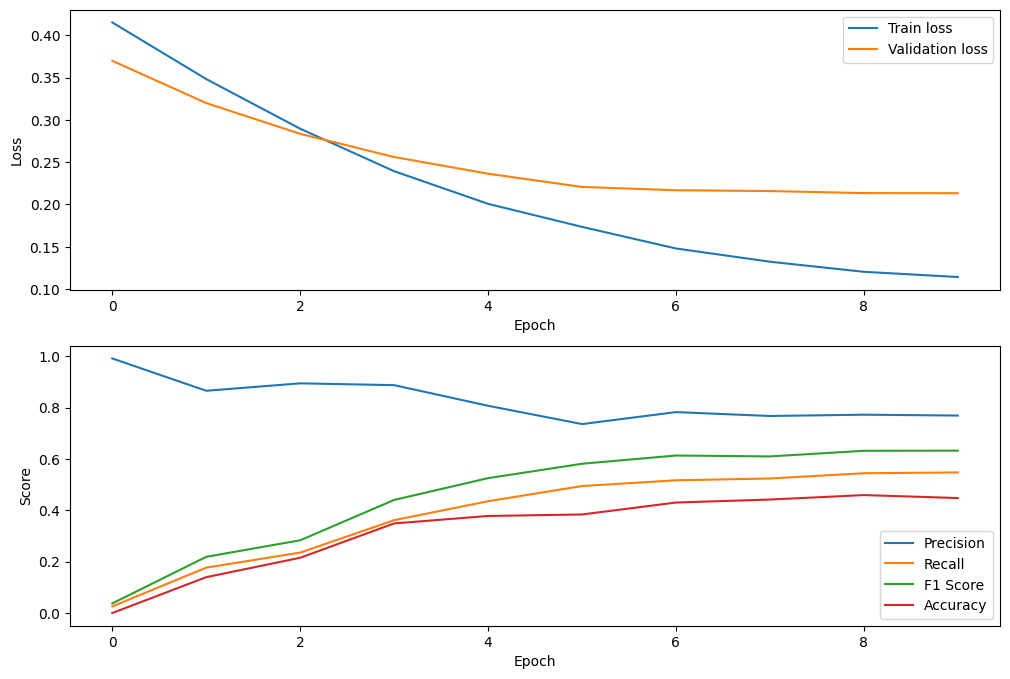

In [38]:
import matplotlib.pyplot as plt

# Fonction pour tracer les résultats d'entraînement
def plot_history(history):
    plt.figure(figsize=(12, 8))
    
    # Loss
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Precision, Recall, F1 Score, Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(history['precision'], label='Precision')
    plt.plot(history['recall'], label='Recall')
    plt.plot(history['f1'], label='F1 Score')
    plt.plot(history['accuracy'], label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.show()

plot_history(history)


ACCURACY

In [ ]:
from sklearn.metrics import accuracy_score

def calculate_accuracies(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_labels = 0
    label_correct = torch.zeros(len(mlb.classes_), dtype=torch.float32)
    label_total = torch.zeros(len(mlb.classes_), dtype=torch.float32)

    with torch.no_grad():
        for d in data_loader:
            bio_input_ids = d['bio_input_ids'].to(device)
            bio_attention_mask = d['bio_attention_mask'].to(device)
            caption_input_ids = d['caption_input_ids'].to(device)
            caption_attention_mask = d['caption_attention_mask'].to(device)
            hashtag_input_ids = d['hashtag_input_ids'].to(device)
            hashtag_attention_mask = d['hashtag_attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                bio_input_ids=bio_input_ids,
                bio_attention_mask=bio_attention_mask,
                caption_input_ids=caption_input_ids,
                caption_attention_mask=caption_attention_mask,
                hashtag_input_ids=hashtag_input_ids,
                hashtag_attention_mask=hashtag_attention_mask
            )

            preds = torch.sigmoid(outputs) > 0.5
            # Compute accuracy
            correct = (preds == labels).float()  # Convert boolean to float for calculation
            total_correct += correct.sum().item()  # Sum up all correct predictions
            total_labels += labels.numel()  # Count total predictions
            
            # Accuracy per label
            label_correct += correct.sum(dim=0)
            label_total += labels.size(0)

    overall_accuracy = total_correct / total_labels  # Calculate overall accuracy
    label_accuracy = label_correct / label_total  # Calculate per label accuracy
    
    return overall_accuracy, label_accuracy

model.load_state_dict(torch.load('best_model_epoch_10.pth'))
# Use the function to evaluate the model
overall_accuracy, label_accuracy = calculate_accuracies(model, val_loader, device)
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print("Label-wise Accuracy:")
for label, acc in zip(mlb.classes_, label_accuracy):
    print(f"{label}: {acc:.4f}")